In [1]:
using Distributions
using Random
using StatsPlots
default(fmt = :png, size = (640, 400),
    titlefontsize = 10, plot_titlefont = 10)

In [2]:
function confdist(m, x̄, sx²)
    SEhat = √(sx²/m)
    x̄ + SEhat * TDist(m - 1)
end

function confdist(x)
    m, x̄, sx² = length(x), mean(x), var(x)
    confdist(m, x̄, sx²)
end

function tvalue(m, x̄, sx², μ = 0.0)
    (x̄ - μ) / √(sx²/m)
end

function tvalue(x, μ = 0.0)
    m, x̄, sx² = length(x), mean(x), var(x)
    tvalue(m, x̄, sx², μ)
end

function pvalue(m, x̄, sx², μ = 0.0)
    t = tvalue(m, x̄, sx², μ)
    ν = m - 1
    2ccdf(TDist(ν), abs(t))
end

function pvalue(x, μ = 0.0)
    m, x̄, sx² = length(x), mean(x), var(x)
    pvalue(m, x̄, sx², μ)
end

function confint(m, x̄, sx²; α = 0.05)
    ν = m - 1
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²/m)
    [x̄ - c*SEhat, x̄ + c*SEhat]
end

function confint(x; α = 0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    confint(m, x̄, sx²; α)
end

function preddist(m, x̄, sx²)
    SEhat = √(sx²*(1+1/m))
    x̄ + SEhat * TDist(m - 1)
end

function preddist(x)
    m, x̄, sx² = length(x), mean(x), var(x)
    preddist(m, x̄, sx²)
end

function tvalue_pred(m, x̄, sx², xnew)
    (x̄ - xnew) / √(sx²*(1+1/m))
end

function tvalue_pred(x, xnew)
    m, x̄, sx² = length(x), mean(x), var(x)
    tvalue_pred(m, x̄, sx², xnew)
end

function pvalue_pred(m, x̄, sx², xnew)
    t = tvalue_pred(m, x̄, sx², xnew)
    ν = m - 1
    2ccdf(TDist(ν), abs(t))
end

function pvalue_pred(x, xnew)
    m, x̄, sx² = length(x), mean(x), var(x)
    pvalue_pred(m, x̄, sx², xnew)
end

function predint(m, x̄, sx²; α = 0.05)
    ν = m - 1
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²*(1+1/m))
    [x̄ - c*SEhat, x̄ + c*SEhat]
end

function predint(x; α = 0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    confint_pred(m, x̄, sx²; α)
end

predint (generic function with 2 methods)

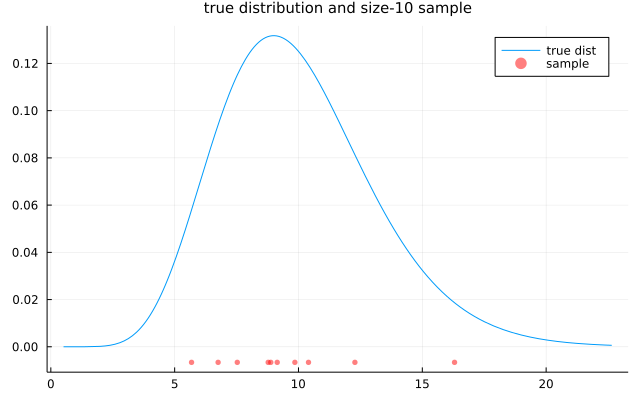

In [3]:
Random.seed!(4649373)

dist_true = Gamma(10, 1)
m = 10
x = rand(dist_true, m)

μ, σ = mean(dist_true), std(dist_true)
a, b = max(minimum(dist_true), μ-3σ), min(maximum(dist_true), μ+4σ)
plot(dist_true, a, b; label="true dist")
h = pdf(dist_true, mode(dist_true))
scatter!(x, fill(-0.05h, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
title!("true distribution and size-$m sample")

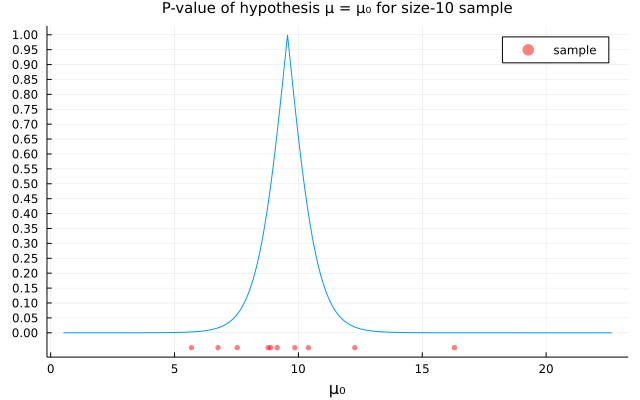

In [4]:
plot(μ₀ -> pvalue(x, μ₀), a, b; label="")
scatter!(x, fill(-0.05, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value of hypothesis μ = μ₀ for size-$m sample")

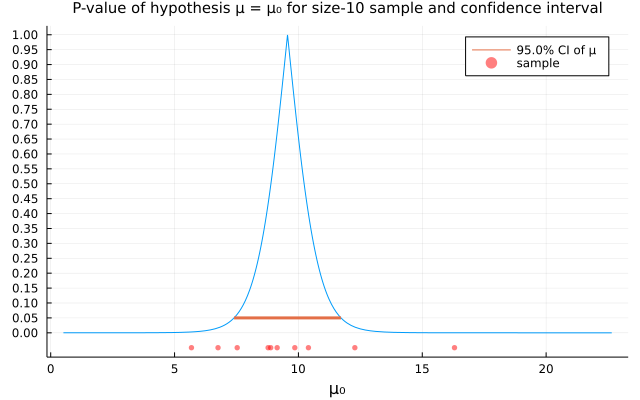

In [5]:
α = 0.05

plot(μ₀ -> pvalue(x, μ₀), a, b; label="")
plot!(confint(x; α), fill(α, 2); label="$(100(1-α))% CI of μ", lw=3)
scatter!(x, fill(-0.05, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value of hypothesis μ = μ₀ for size-$m sample and confidence interval")

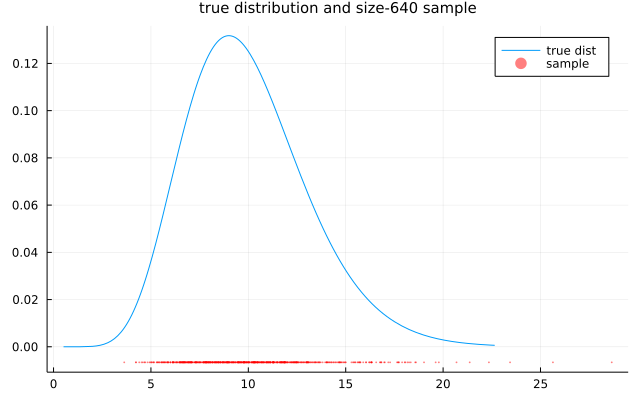

In [6]:
Random.seed!(4649373)

dist_true = Gamma(10, 1)
m = 640
x = rand(dist_true, m)

μ, σ = mean(dist_true), std(dist_true)
a, b = max(minimum(dist_true), μ-3σ), min(maximum(dist_true), μ+4σ)
plot(dist_true, a, b; label="true dist")
h = pdf(dist_true, mode(dist_true))
scatter!(x, fill(-0.05h, m); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
title!("true distribution and size-$m sample")

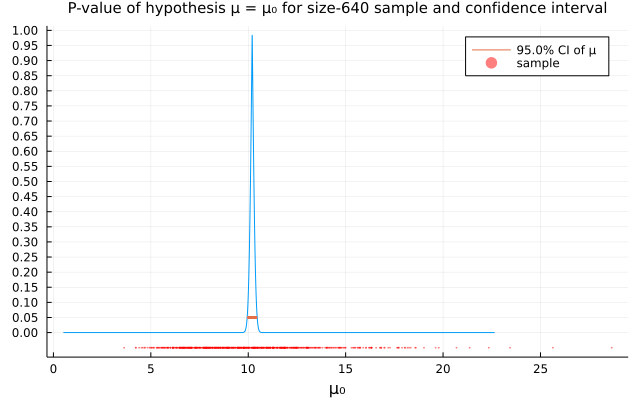

In [7]:
α = 0.05

plot(μ₀ -> pvalue(x, μ₀), a, b; label="")
plot!(confint(x; α), fill(α, 2); label="$(100(1-α))% CI of μ", lw=3)
scatter!(x, fill(-0.05, m); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value of hypothesis μ = μ₀ for size-$m sample and confidence interval")

In [8]:
function plot_ttest(;
        dist_true = Gamma(10, 1),
        m = 10,
        x = rand(dist_true, m))

    μ, σ = mean(dist_true), std(dist_true)
    a, b = max(minimum(dist_true), μ - 5σ), min(maximum(dist_true), μ + 5σ)

    P1 = plot(μ -> pvalue(x, μ), a, b; label="P-value")
    scatter!(x, fill(-0.05, length(x)); label="sample", ms=2, msc=:auto, alpha=0.5, c=:red)

    P2 = plot(xnew -> pdf(confdist(x), xnew), a, b; label="conf dist")
    h = pdf(confdist(x), mode(confdist(x)))
    scatter!(x, fill(-0.05h, length(x)); label="sample", ms=2, msc=:auto, alpha=0.5, c=:red)

    P3 = plot(xnew -> pvalue_pred(x, xnew), a, b; label="pred P-value")
    scatter!(x, fill(-0.05, length(x)); label="sample", ms=2, msc=:auto, alpha=0.5, c=:red)

    P4 = plot(xnew -> pdf(preddist(x), xnew), a, b; label="pred dist")
    plot!(dist_true, a, b; label="true dist", ls=:dash)
    h = pdf(preddist(x), mode(preddist(x)))
    scatter!(x, fill(-0.05h, length(x)); label="sample", ms=2, msc=:auto, alpha=0.5, c=:red)

    plot(P1, P2, P3, P4; size=(800, 500), layout=(2, 2))
    plot!(; plot_title="P-value function, etc. for size-$m sample of $(dist_true)")
end

plot_ttest (generic function with 1 method)

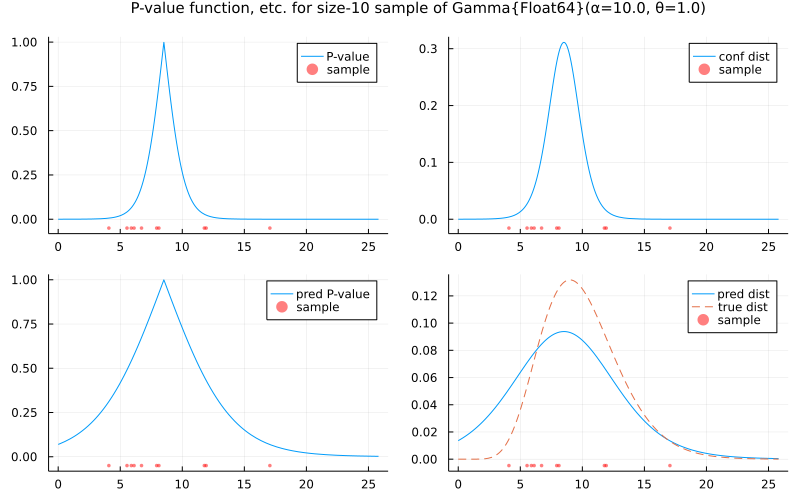

In [9]:
plot_ttest(m = 10)

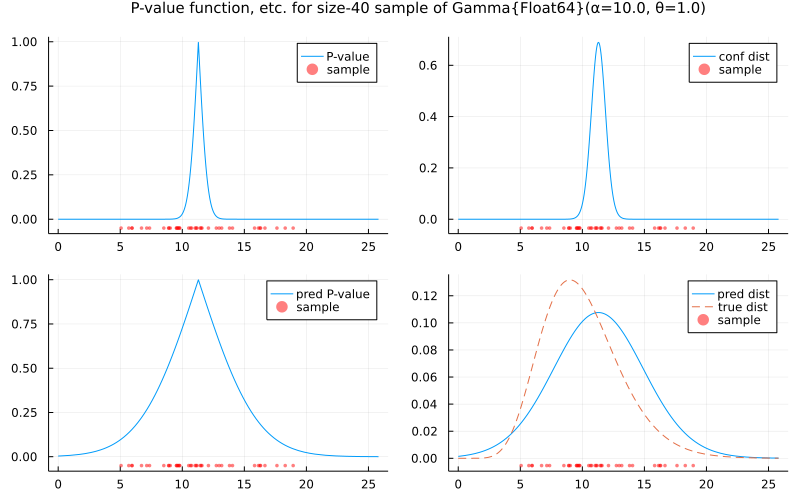

In [10]:
plot_ttest(m = 40)

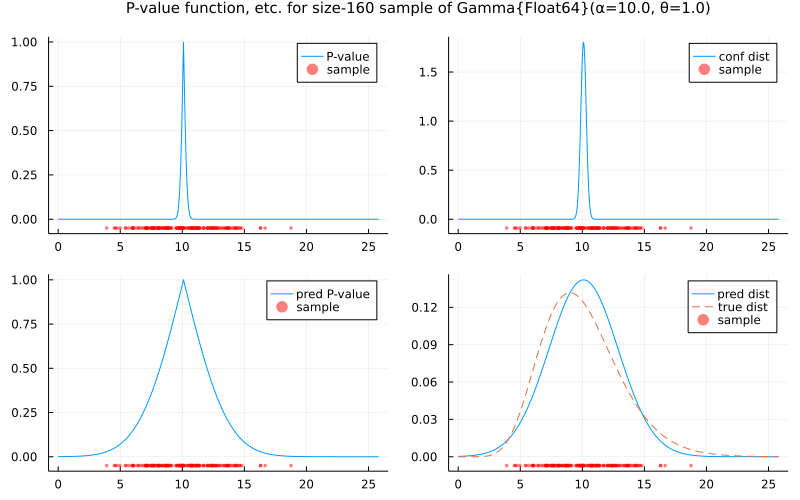

In [11]:
plot_ttest(m = 160)

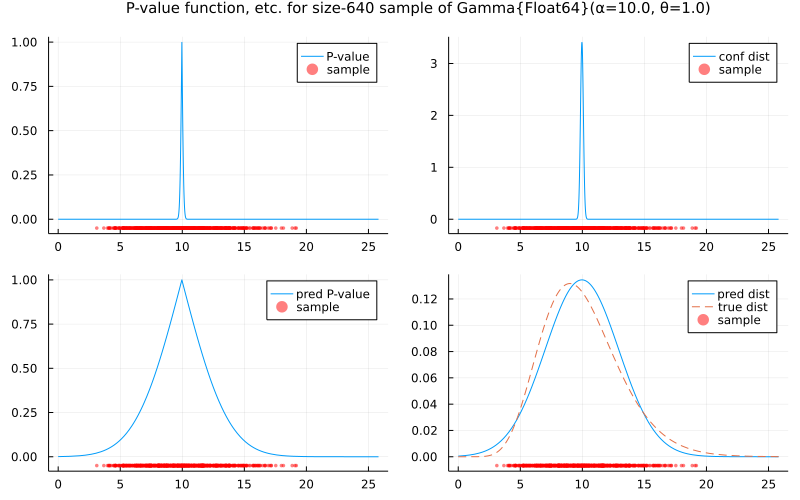

In [12]:
plot_ttest(m = 640)